# Oil Spill Detection Use Case Example

In [35]:
import asf_search as asf
import getpass
from os import listdir
import pyroSAR
from pyroSAR.snap.auxil import parse_recipe, parse_node, gpt, groupbyWorkers
from pyroSAR.S1 import OSV
from pyroSAR import identify
import tensorflow as tf
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.enums import Resampling
from matplotlib import pyplot as plt
import numpy as np
import json
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import transform
import folium
import pyproj
import keras
from patchify import patchify, unpatchify
from skimage import io, exposure, data
import cv2

# Download Sentinel-1 image from Alaska Satellite Facility (ASF)

In [3]:
session = asf.ASFSession()

username = input('Username:')
password = getpass.getpass('Password:')

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Username:mohammedkhalid056@gmail.com
Password:········
Success!


In [4]:
directory = r'./'

granule = 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13'

result = asf.granule_search(granule)
# print(result)

# result.download(path=directory, session=user_pass_session)

listdir(directory)

['.ipynb_checkpoints',
 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.zip',
 'SAR_preprocessing.ipynb',
 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.iso.xml']

In [52]:
scene = 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.zip'
id = identify(scene)
match = id.getOSV(osvType='POE', returnMatch=True)
print(match)

searching for new POE files
https://scihub.copernicus.eu/gnss/search/?q=producttype:AUX_POEORB platformname:Sentinel-1 filename:S1B* beginPosition:[2019-10-12T03:21:40Z TO 2019-10-14T03:21:40Z] endPosition:[2019-10-12T03:21:40Z TO 2019-10-14T03:21:40Z]&format=json
found 1 OSV results
downloading 1 file
deleting 0 RES files
/home/users/b90068501/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2019/10/S1B_OPER_AUX_POEORB_OPOD_20210305T013042_V20191012T225942_20191014T005942.EOF.zip


# Preprocess the Sentinel-1 image using SNAP API

In [12]:
workflow = parse_recipe('blank')

read = parse_node('Read')
read.parameters['file'] = './S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.zip'
read.parameters['formatName'] = 'SENTINEL-1'
workflow.insert_node(read)

sbs = parse_node('Subset')
sbs.parameters['copyMetadata'] = True
sbs.parameters['sourceBands'] = ['VV']
workflow.insert_node(sbs, before=read.id)

orb = parse_node('Apply-Orbit-File')
orb.parameters['orbitType'] = 'Sentinel Precise (Auto Download)'
orb.parameters['continueOnFail'] = True
workflow.insert_node(orb, before=read.id)

tnr = parse_node('ThermalNoiseRemoval')
tnr.parameters['removeThermalNoise'] = 'true'
workflow.insert_node(tnr, before=read.id)

bnr = parse_node('Remove-GRD-Border-Noise')
bnr.parameters['selectedPolarisations'] = ['VV']
workflow.insert_node(bnr, before=tnr.id)

lnd = parse_node('Land-Sea-Mask')
lnd.parameters['landMask'] = 'true'
workflow.insert_node(lnd, before=bnr.id)

cal = parse_node('Calibration')
cal.parameters['outputSigmaBand'] = 'true'
cal.parameters['sourceBands'] = 'Intensity_VV'
cal.parameters['selectedPolarisations'] = 'VH,VV'
cal.parameters['outputImageScaleInDb'] = 'false'
workflow.insert_node(cal, before=lnd.id)

spk = parse_node('Speckle-Filter')
spk.parameters['filter'] = 'Lee Sigma'
spk.parameters['filterSizeX'] = '3'
spk.parameters['filterSizeY'] = '3'
workflow.insert_node(spk, before=cal.id)

db = parse_node('LinearToFromdB')
db.parameters['sourceBands'] = 'Sigma0_VV'
workflow.insert_node(db, before=spk.id)

und = parse_node('Undersample')
und.parameters['method'] = 'LowPass Filtering'
und.parameters['outputImageBy'] = 'Pixel Spacing'
und.parameters['filterSize'] = '3x3'
und.parameters['rangeSpacing'] = '80'
und.parameters['azimuthSpacing'] = '80'
workflow.insert_node(und, before=db.id)

prj = parse_node('Ellipsoid-Correction-GG')
prj.parameters['mapProjection'] = 'WGS84(DD)'
workflow.insert_node(prj, before=und.id)

write = parse_node('Write')
write.parameters['file'] = '20191013T032140_preprocessed'
write.parameters['formatName'] = 'GeoTIFF'
workflow.insert_node(write, before=prj.id)

workflow.write('20191013T032140_preprocessed')

In [14]:
gpt(xmlfile = '20191013T032140_preprocessed.xml', outdir='./', groups=groupbyWorkers('20191013T032140_preprocessed.xml', n=1))

executing node sequences..
ThermalNoiseRemoval
Remove-GRD-Border-Noise
Land-Sea-Mask
Calibration
Speckle-Filter
LinearToFromdB
Undersample
Ellipsoid-Correction-GG
done


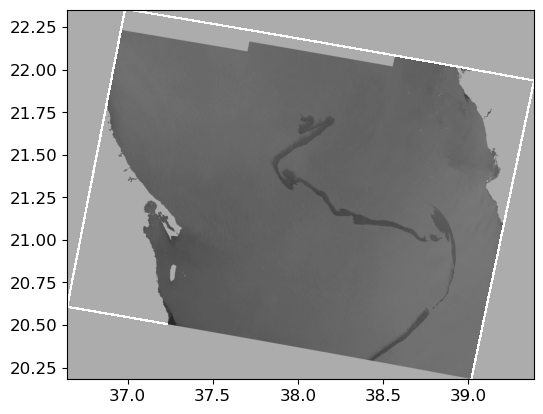

In [20]:
image = rasterio.open('./20191013T032140_preprocessed.tif')
show(image, cmap='gray')
plt.show()

# Prepare the data for deep learning model inference

In [37]:
def load_geotiff_image(file_path):
    """
    A function that uses the rasterio library to read a GeoTIFF image and convert it into a numpy array
    """
    scale_factor = 0.5
    
    with rasterio.open(file_path) as dataset:

    # resample data to target shape
#         data = dataset.read(out_shape=(dataset.count, int(dataset.height * scale_factor), int(dataset.width * scale_factor)), resampling=Resampling.bilinear)
        data = dataset.read()

    # scale image transform
#         transform = dataset.transform * dataset.transform.scale((dataset.width / data.shape[-1]),(dataset.height / data.shape[-2]))
    
    #rearrage the order of the image channel from first to last
    image = np.moveaxis(data, 0, -1)
    return image

def normalise(input_image):
    n_image = (input_image - input_image.min()) / (input_image.max()- input_image.min())
    return n_image

def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.uint8), mask=(mask >0), connectivity=8, transform=transform):
#         return shapely.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    
    return all_polygons

def pad_image(image):
    # Step 1: Determine patch size and number of patches needed in each dimension
    rows, cols, _ = image.shape
    num_rows = rows // 512
    num_cols = cols // 512
    
    # Step 2: Calculate padding needed
    pad_rows = 512 - (rows % 512)
    pad_cols = 512 - (cols % 512)
    
    # Step 3: Pad the original image with the calculated padding
    image_padded = np.pad(image, ((0, pad_rows), (0, pad_cols), (0, 0)), mode='constant')
    return image_padded

def remove_small_regions(mask, min_size):
    # Perform morphological opening on the mask using a rectangular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Find all connected components in the opened mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask, connectivity=8)

    # Remove small regions by setting them to background
    cleaned_mask = np.zeros_like(mask)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size:
            cleaned_mask[labels == label] = 1

    return cleaned_mask

In [38]:
large_image = load_geotiff_image('./20191013T032140_preprocessed.tif')

large_image = np.array(large_image)
large_image[np.isnan(large_image)] = 0

print("Before padding:", large_image.shape)
large_image = pad_image(large_image)
print("After padding:", large_image.shape)

# Create a masked array where values greater than 0 are masked
masked_array = np.ma.masked_greater(large_image, -1)
# Calculate median of the unmasked values
large_image[(large_image >= -1.0)] = np.ma.median(masked_array)

percentiles = np.percentile(large_image, (0.5, 99.5))
scaled = exposure.rescale_intensity(large_image, in_range=tuple(percentiles))
large_image = normalise(scaled)

# Plot histogram of the modified numpy array
# plt.hist(large_image.flatten(), bins=50, color='green', alpha=0.5)
# plt.title('Histogram of Modified Numpy Array')
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.show()

Before padding: (3021, 3812, 1)
After padding: (3072, 4096, 1)


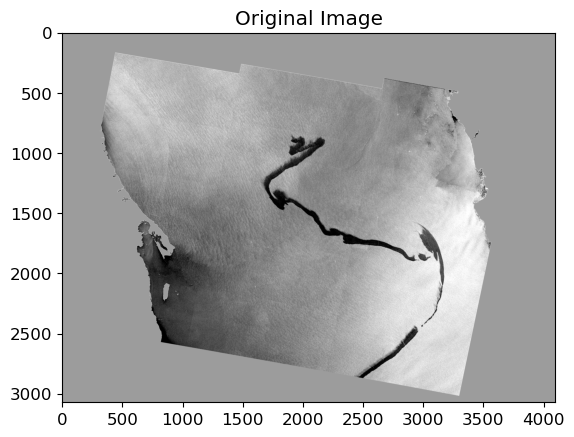

In [39]:
plt.title("Original Image")
plt.imshow(large_image[:, :, 0], cmap='gray')
plt.show()

# Pass the image into the model

In [40]:
unet = keras.models.load_model('/home/users/b90068501/diss/unet_200epc_aug_best_20230330.h5', compile=False)
deeplab = keras.models.load_model('/home/users/b90068501/diss/deeplabv3_200epc_aug_best_20230330.h5', compile=False)

In [41]:
size_x = (large_image.shape[0]//512)*512
size_y = (large_image.shape[1]//512)*512
large_image = np.array(large_image)
large_image = large_image[0:size_x,0:size_y]
patches_img = patchify(large_image, (512,512,1), step=512)
patches_img = patches_img[:,:,0,:,:,:]
print(patches_img.shape)

(6, 8, 512, 512, 1)


(-0.5, 4095.5, 3071.5, -0.5)

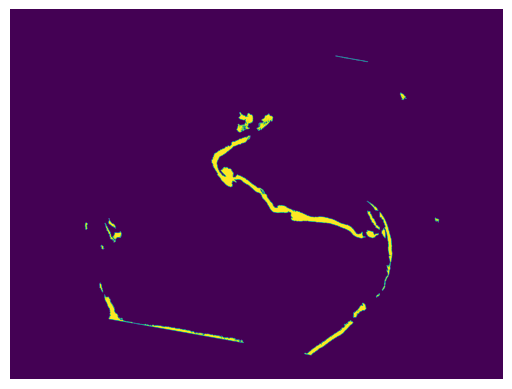

In [42]:
patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i,j,:,:,:]
        single_patch_img = tf.convert_to_tensor(single_patch_img)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        single_patch_img = np.expand_dims(single_patch_img, axis=-1)
        unet_patchify_pred = unet.predict(single_patch_img, verbose=0)
        deeplab_patchify_pred = deeplab.predict(single_patch_img, verbose=0)
        weighted_patchify_pred = np.tensordot(np.array([deeplab_patchify_pred, unet_patchify_pred]), [0.5, 0.5], axes=((0),(0)))
        weighted_patchify_pred_t = (weighted_patchify_pred > 0.5).astype(np.uint8)
        weighted_patchify_pred_t = np.squeeze(weighted_patchify_pred_t)
        weighted_patchify_pred_t = remove_small_regions(weighted_patchify_pred_t, 300)
        patched_prediction.append(weighted_patchify_pred_t)


patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_image.shape[0], large_image.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')  

# Copy coordinate system information and transformation parameters from original image

In [43]:
#Copy metadata from original GeoTIFF file
scale_factor = 0.5
with rasterio.open("./20191013T032140_preprocessed.tif") as dataset:
    
    # resample data to target shape
#     data = dataset.read(out_shape=(dataset.count, int(dataset.height * scale_factor), int(dataset.width * scale_factor)), resampling=Resampling.bilinear)
    data = dataset.read()
 
    # scale image transform
#     transform = dataset.transform * dataset.transform.scale((dataset.width / data.shape[-1]),(dataset.height / data.shape[-2]))
    transform = dataset.transform
    
    # Get a copy of the source dataset's profile. Thus our
    # destination dataset will have the same dimensions,
    # number of bands, data type, and georeferencing as the
    # source dataset.
    kwds = dataset.profile
#     print('kwds before:')
#     print(kwds)
    kwds['height'] = 512
    kwds['width'] = 512
    kwds['transform'] = transform
#     print('kwds after:')
    print(kwds)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0007186522272956172, 0.0, 36.646757845394674,
       0.0, -0.0007186522272956172, 22.352333999851442), 'tiled': False, 'interleave': 'band'}


# Plot the model's predictions on a map

In [54]:
polys = mask_to_polygons_layer(unpatched_prediction)
wgs84 = pyproj.CRS('EPSG:4326')

#Find the centroid to position the map
centroidp = MultiPolygon(polys).centroid

# wgspolys = polys.to_crs("EPSG:4326").to_json()

long = centroidp.x
lat = centroidp.y

#Find spatial mean
long = np.mean(long)

#Plot it
mymap = folium.Map(location=[lat, long], tiles='openstreetmap', zoom_start=8)
plotpoly =folium.features.GeoJson(polys)
mymap.add_child(plotpoly)

mymap